# Tutorial: Gaussian Processes in Julia with Stheno

This tutorial gives an introduction to Gaussian processes and their implementation in the [STheno](https://github.com/willtebbutt/Stheno.jl) package in the Julia ecosystem. The tutorial is based on a selected amalgamation of the STheno [tutorial](https://willtebbutt.github.io/Stheno.jl/stable/getting_started/), questions one usually has to figure out when seeking to employ Gaussian processes in research or in production and a selected step-by-step [example](https://github.com/willtebbutt/stheno_models/blob/master/exact/simple_sensor_fusion.jl).

## Outline:

**Section 1.** [Construction of a Gaussian process](#construction)

**Section 2.** [Fitting a GP with BFGS](#bfgs)

**Section 3.** [Approximate Bayesian inference of the GPs hyperparameters](#approximate)

**Section 4.** [Exercise 1](#ex1)

**Section 5.** [Sensor fusion with Stheno](#fusion)

**Section 6.** [Exercise 2](#ex2)

In [6]:
using Stheno, Plots, Optim

In [7]:
using Random, Statistics, ORCA

In [8]:
using Stheno: @model, EQ, Noise

## 1: Construct a first Gaussian process <a name="construction"></a>

In [9]:
# Choose the length-scale and variance of the process
l = 0.4
σ² = 1.3;

Choose a kernel from the available kernels in Stheno and feed the kernel to the gaussian process, where `GPC` is a mutable structure containing the collection of GPs and is used to keep track of the GP constructed in this case. It is comparable to a `trace` in a probabilistic program; a structure to store all results of the model.

In [10]:
# Construct a kernel
k = σ² * stretch(matern52(), 1 / l)

# Construct a zero-mean GP with the kernel
f = GP(k, GPC());

Generate an initial sample from the GP we previously defined

In [11]:
# Generate a sample from the GP
const x = randn(100)
σ²_n = 0.05
fx = f(x, σ²_n)
const y = rand(fx);

Calculate the logarithmic probability between `f` at `x` (fx) and `y`, where the logarithmic probability is used as it is easier, and more accurate to calculate for a computer and the negative log probability represents the information content of our measurement.

In [12]:
# Compute the log marginal likelihood for this observation
logpdf(fx, y)

-29.40065163802705

Visualize the data we are working with

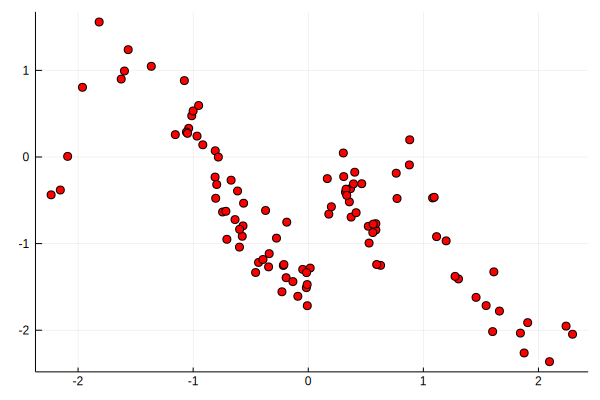

In [13]:
using Plots

plt = plot();
scatter!(plt, x, y; color=:red, label="");
display(plt);

Compute the posterior over f

In [14]:
f_posterior = f | Obs(fx, y);

Visualize the fit of our gaussian process to the data

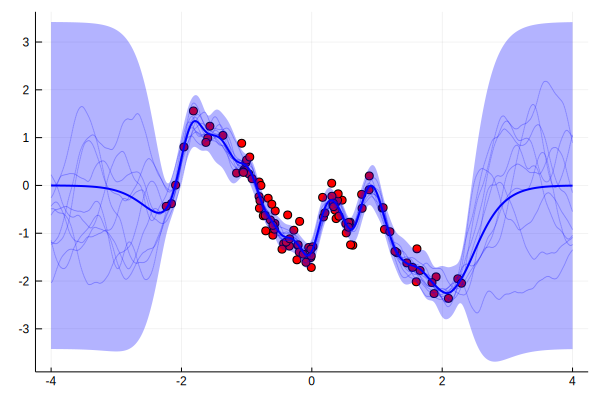

In [15]:
# Visualize the posterior
x_plot = range(-4.0, 4.0; length=1000);
plot!(plt, f_posterior(x_plot); samples=10, label="", color=:blue);
display(plt);

## 2: GP fitting with BFGS using Zygote.jl <a name="bfgs"></a>

In [17]:
function unpack(θ)
    σ² = exp(θ[1]) + 1e-6
    l = exp(θ[2]) + 1e-6
    σ²_n = exp(θ[3]) + 1e-6
    return σ², l, σ²_n
end

# nlml = negative log marginal likelihood (of θ)
function nlml(θ)
    σ², l, σ²_n = unpack(θ)
    k = σ² * stretch(matern52(), 1 / l)
    f = GP(k, GPC())
    return -logpdf(f(x, σ²_n), y)
end

nlml (generic function with 1 method)

The BFGS optimiztion algorithm usually delivers the fastest convergence for smaller-sized Gaussian processes. It requires access to first-order gradients, which is why use Zygote's reverse-mode algorithmic differentiation.

In [ ]:
using Zygote: gradient

# Set up the optimization
θ0 = randn(3)
results = Optim.optimize(nlml, θ->gradient(nlml, θ)[1], θ0, BFGS(); inplace=false)
σ²_bfgs, l_bfgs, σ²_n_bfgs = unpack(results.minimizer);

Visualize the posterior

In [ ]:
k = σ²_bfgs * stretch(matern52(), 1 / l_bfgs);
f = GP(k, GPC());
f_posterior_bfgs = f | Obs(f(x, σ²_n_bfgs), y);
plot!(plt, f_posterior_bfgs(x_plot); samples=10, color=:purple, label="");
display(plt);

## 3: Approximate Bayesian inference of the GP's hyperparameters <a name="approximate"></a>

Use AdvancedHMC, for an optimized version of the No-U-Turns sampler, which relies on Zygote to obtain gradients

In [ ]:
using AdvancedHMC, Zygote

Define the model we want to sample from including gradients to accelerate convergence

In [ ]:
# Define the log marginal likelihood function and its gradient
lπ(θ) = -nlml(θ)
function dlπdθ(θ)
    lml, back = Zygote.pullback(lπ, θ)
    dθ = first(back(1.0))
    return lml, dθ
end;

Define the number of samples and the number of adaptations, if you have patience you can loop over different numbers of samples to get a convergence plot of the inference algorithm.

In [ ]:
# Sampling parameter settings
n_samples, n_adapts = 100, 20

# Draw random starting points
θ0 = randn(3);

Set up the inference algorithm by first constructing the Hamiltonian for our model problem and then calibrating the No-U-Turn sampler and the leapfrogging algorithm

In [ ]:
# Define metric space, Hamiltonian, sampling method and adaptor
metric = DiagEuclideanMetric(3)
h = Hamiltonian(metric, lπ, dlπdθ)
int = Leapfrog(find_good_eps(h, θ0))
prop = NUTS{MultinomialTS, GeneralisedNoUTurn}(int)
adaptor = StanHMCAdaptor(n_adapts, Preconditioner(metric), NesterovDualAveraging(0.8, int.ϵ));

Sample from the constructed Hamiltonian 100 times

In [ ]:
# Perform inference
samples, stats = sample(h, prop, θ0, n_samples, adaptor, n_adapts; progress=true);

Inspect the posterior by plotting the convergence of its performance parameters

In [ ]:
# Inspect posterior distribution
hypers = unpack.(samples);
plt_hypers = plot();
plot!(plt_hypers, getindex.(hypers, 1); label="variance");
plot!(plt_hypers, getindex.(hypers, 2); label="length scale");
plot!(plt_hypers, getindex.(hypers, 3); label="obs noise variance");
display(plt_hypers);

## 4: Exercise 1 <a name="ex1"></a>

- Experiment with different available kernels, Stheno offers a number of different [kernels](https://github.com/willtebbutt/Stheno.jl/blob/master/src/gp/kernel.jl), such as:
    - Exponential kernel
    - Exponentiated quadratic kernel
    - Matern 32 kernel
    - Matern 52 kernel
    - Rational quadratic kernel `RQ(alpha)`, with kurtosis `alpha`
    - Cosine kernel `Cosine(Tp)`, with period parameter `p`
    - Gamma-Exponential kernel `GammaExp(Tgamma)`, where $0 < \gamma \leq 2$
    - ..
- How do the different kernels affect the posterior in an approximate Bayesian inference setting?
- How does the number of samples, needed for an expressive posterior, change with the kernel choice?
- Redefine nlml to make it a probabilistic model

## 5: Example: Sensor fusion with STheno <a name="fusion"></a>

Here we assume `f` to be a real-valued function whose form and parameterization is unknown to us, which we hence seek to infer from data. This is an inverse problem for which Stheno and probabilistic programming are especially suited.

Here we assume to have two sensor, whose measurements we are able to access. For the first sensor's measurements we assume:
$\mu = \sin(x) - 5 + \sqrt{abs(x)}$
$\sigma^{2} = 1e-2$

And for the second sensor we assume to have a bias of `3.5`. From this we can construct our Bayesian model:

In [ ]:
@model function model()
    
    # We wish to infer a smooth latent process
    f = GP(EQ())
    
    # Define the two noisy sensor measurements described above
    noise1 = sqrt(1e-2) * GP(Noise()) + (x->sin.(x) .- 5.0 .+ sqrt.(abs.(x)))
    noise2 = sqrt(1e-1) * GP(3.5, Noise())
    
    # Define the observation processes
    y1 = f + noise1
    y2 = f + noise2
    
    return f, noise1, noise2, y1, y2
end

Instantiate variables with initial model measurement

In [ ]:
f, noise₁, noise₂, y₁, y₂ = model();

Generate a toy dataset to test the validity of our approach

In [ ]:
rng = MersenneTwister(123456)

X₁, X₂ = sort(rand(rng, 3) * 10), sort(rand(rng, 10) * 10);
ŷ₁, ŷ₂ = rand(rng, [y₁(X₁), y₂(X₂)]);

Compute the posteriors

In [ ]:
(f′, y₁′, y₂′) = (f, y₁, y₂) | (y₁(X₁)←ŷ₁, y₂(X₂)←ŷ₂);

Sample from the posterior processes

In [ ]:
Xp = range(-2.5, stop=12.5, length=500);
f′Xp, y₁′Xp, y₂′Xp = rand(rng, [f′(Xp, 1e-9), y₁′(Xp, 1e-9), y₂′(Xp, 1e-9)], 100);

Compute the posterior marginals

In [ ]:
ms1 = marginals(f′(Xp));
ms2 = marginals(y₁′(Xp));
ms3 = marginals(y₂′(Xp));

μf′, σf′ = mean.(ms1), std.(ms1);
μy₁′, σy₁′ = mean.(ms2), std.(ms2);
μy₂′, σy₂′ = mean.(ms3), std.(ms3);

Initialize the plot

In [ ]:
plotly();

posterior_plot = plot();

Add the posterior marginal standard deviation to the plot

In [ ]:
plot!(posterior_plot, Xp, [μy₁′ μy₁′];
    linewidth=0.0,
    fillrange=[μy₁′ .- 3 .* σy₁′, μy₁′ .+ 3 * σy₁′],
    fillalpha=0.3,
    fillcolor=:red,
    label="");
plot!(posterior_plot, Xp, [μy₂′ μy₂′];
    linewidth=0.0,
    fillrange=[μy₂′ .- 3 .* σy₂′, μy₂′ .+ 3 * σy₂′],
    fillalpha=0.3,
    fillcolor=:green,
    label="");
plot!(posterior_plot, Xp, [μf′ μf′];
    linewidth=0.0,
    fillrange=[μf′.- 3  .* σf′ μf′ .+ 3 .* σf′],
    fillalpha=0.5,
    fillcolor=:blue,
    label="");

Add the posterior marginal samples to the plot

In [ ]:
scatter!(posterior_plot, Xp, y₁′Xp,
    markercolor=:red,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=0.5,
    markeralpha=0.3,
    label="");
scatter!(posterior_plot, Xp, y₂′Xp,
    markercolor=:green,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=0.5,
    markeralpha=0.3,
    label="");
plot!(posterior_plot, Xp, f′Xp;
    linecolor=:blue,
    linealpha=0.2,
    label="");

Add the posterior mean to the plot

In [ ]:
plot!(posterior_plot, Xp, μy₁′;
    linecolor=:red,
    linewidth=2.0,
    label="");
plot!(posterior_plot, Xp, μy₂′;
    linecolor=:green,
    linewidth=2.0,
    label="");
plot!(posterior_plot, Xp, μf′;
    linecolor=:blue,
    linewidth=2.0,
    label="Latent Function");

Add the posterior of the first noise process to the plot

In [ ]:
scatter!(posterior_plot, X₁, ŷ₁;
    markercolor=:red,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=4,
    markeralpha=0.8,
    label="Sensor 1");
scatter!(posterior_plot, X₂, ŷ₂;
    markercolor=:green,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=4,
    markeralpha=0.8,
    label="Sensor 2");

Have a look at the posterior plot

In [ ]:
display(posterior_plot)

## 6: Exercise 2 <a name="ex2"></a>

- What would change if we were to assume a different probability distribution over the noise in above model?
- Redefine the model as a probabilistic model using [Gen](https://github.com/probcomp/Gen)
          Hint: Have a look at the `Bayesian Linear Regression` example in the `Regression` notebook